## Brain decoding prediction analysis

This notebook compares quantitative properties of the brain decoder predictions for different trained decoders / subjects / target representations.

In [1]:
from collections import defaultdict
import itertools
from pathlib import Path
import re
import sys

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io
from scipy import stats as st
from tqdm import tqdm_notebook
sns.set_style("whitegrid")

%load_ext autoreload
%autoreload 2

sys.path.append("../src")
from rsa import rsa_encodings
import util

In [2]:
decoder_path = Path("../models/decoders")
bert_encoding_path = Path("../models/bert")
sentences_path = Path("../data/sentences/stimuli_384sentences.txt")
brains_path = Path("../data/brains")

bert_base_model = "uncased_L-12_H-768_A-12"
finetune_desc = "finetune-250"

In [3]:
bert_models = ["SST", "SQuAD", "LM_pos", "MNLI", "QQP", "LM", "LM_contentonly", "LM_lmonly", "LM_randommask", "LM_scrambled", "LM_scrambled_para", "LM_contentonly_scrambled", "LM_lmonly_scrambled"]
# Models which should appear in the final report figures
report_models = ["SQuAD", "QQP", "MNLI", "SST", "LM", "LM_scrambled", "LM_pos"]
subjects = ["M02", "M04", "M07", "M08", "M09", "M14", "M15", "P01"]
target_runs = [1, 2, 3, 4, 5, 6, 7, 8, 9]
steps = list(range(5, 255, 5))

In [4]:
figure_path = Path("../reports/figures")
figure_path.mkdir(exist_ok=True)

### Data loading

In [5]:
PCA_DIM = 256

In [6]:
# Load model encoding data.
encodings = {}
steps_of_interest = [steps[-1]]
for model, run, step in tqdm_notebook(list(itertools.product(bert_models, target_runs, steps_of_interest)), desc="Loading model steps"):
    encoding_name = "encodings.%s.%s.%s-run%i-%i.npy" % (finetune_desc, bert_base_model, model, run, step)
    encoding_path = bert_encoding_path / encoding_name

    try:
        encodings[model, run, step] = util.load_encodings([encoding_path], project=PCA_DIM)
    except FileNotFoundError:
        print(model, run, step)
        continue

SST 9 250
SQuAD 9 250
LM_pos 5 250
LM_pos 6 250
LM_pos 7 250
LM_pos 8 250
LM_pos 9 250
MNLI 9 250
QQP 9 250
LM 9 250
LM_contentonly 9 250
LM_lmonly 9 250
LM_randommask 5 250
LM_randommask 6 250
LM_randommask 7 250
LM_randommask 8 250
LM_randommask 9 250
LM_scrambled 9 250
LM_contentonly_scrambled 9 250
LM_lmonly_scrambled 9 250



In [7]:
encs2 = {"/".join(str(x) for x in k): v for k, v in encodings.items()}

In [8]:
np.savez("../models/bert_encodings_20190518-1242.npz", **encs2)

In [9]:
# Load decoder prediction data.
predictions = {}
for subject in tqdm_notebook(subjects, desc="Subjects"):
    for model, run, step in tqdm_notebook(list(itertools.product(bert_models, target_runs, steps_of_interest)), desc="Loading predictions for target models", leave=False):
        decoded_path = decoder_path / ("encodings.%s.%s.%s-run%i-%i-%s.pred.npy" % (finetune_desc, bert_base_model, model, run, step, subject))
        try:
            predictions[model, run, step, subject] = np.load(decoded_path)
        except FileNotFoundError: pass
        
    # Add baseline predictions.
    baseline_path = decoder_path / ("encodings.%s-%s.pred.npy" % (bert_base_model, subject))
    predictions["_", None, None, subject] = np.load(baseline_path)

In [10]:
preds2 = {"/".join(str(x) for x in k): v for k, v in predictions.items()}

In [11]:
np.savez("../models/decoder_predictions_20190518-1242.npz", **preds2)

#### Reload from cache ..

If restarting this notebook, we can hopefully load the cached files instead:

In [12]:
predictions = np.load("../models/decoder_predictions_20190518-1242.npz")
predictions = {tuple(k.split("/")): v for k, v in predictions.items()}
encodings = np.load("../models/bert_encodings_20190518-1242.npz")
encodings = {tuple(k.split("/")): v for k, v in encodings.items()}

In [13]:
# Normalize encodings as in regression.
encodings = {k: v - v.mean(axis=0) for k, v in encodings.items()}
encodings = {k: v / np.linalg.norm(v, axis=1, keepdims=True) for k, v in encodings.items()}

### Prepare sentence data

In [14]:
sentences = util.load_sentences(sentences_path)

### Load original encodings

In [15]:
# Load pretrained model encodings.
encoding_path = bert_encoding_path / ("encodings.%s.npy" % (bert_base_model))
baseline_encoding = util.load_encodings([encoding_path], project=PCA_DIM)

### Error analysis

Averaging across subjects, how does per-sentence error change over time?

In [16]:
pred_mses = {}

In [17]:
for (model, run, step), encodings_i in encodings.items():
    mses = {}
    for subject in subjects:
        try:
            mses_s = np.linalg.norm(encodings_i - predictions[model, run, step, subject], axis=1)
        except:
            continue
        
        mses[subject] = pd.Series(mses_s, name="mse")
        
    if mses:
        pred_mses[model, int(run), int(step)] = pd.concat(mses, names=["subject"])

In [18]:
# Add original encoding MSEs.
original_mses = {}
for subject in subjects:
    original_mses[subject] = pd.Series(np.linalg.norm(baseline_encoding - predictions["_", "None", "None", subject], axis=1),
                                       name="mse")
    pred_mses["_", 0, 250] = pd.concat(mses, names=["subject"])

In [19]:
pred_mses = pd.DataFrame(pd.concat(pred_mses, names=["model", "run", "step"])).sort_index()
pred_mses.index.names = ["model", "run", "step", "subject", "sentence"]

In [20]:
pred_mses.head()

mse
model run step subject sentence          
LM    5   250  M02     0         1.093025
                       1         1.152027
                       2         1.240082
                       3         1.099759
                       4         0.993663

In [21]:
first_mses = pred_mses.loc[pd.IndexSlice["_", 0, 250, :, :], :]
last_mses = pred_mses.loc[pd.IndexSlice[:, :, 250, :, :], :]

In [22]:
first_mses.index = first_mses.index.droplevel((0, 1, 2))

In [23]:
mse_diffs = last_mses.groupby(["model", "run", "step"]) \
    .apply(lambda xs: xs.reset_index(level=(0,1,2), drop=True) - first_mses)

In [24]:
mse_diffs.head()

mse
model run step subject sentence          
LM    5   250  M02     0         0.154565
                       1         0.057586
                       2         0.152983
                       3         0.149212
                       4        -0.010462

In [25]:
mse_diffs["abs_mse"] = mse_diffs.mse.transform(np.abs)

In [26]:
mse_diffs.sort_values("abs_mse", ascending=False)

mse   abs_mse
model               run step subject sentence                    
SST                 4   250  M02     9         0.691626  0.691626
                    2   250  P01     273       0.686129  0.686129
                    6   250  M09     366       0.671658  0.671658
                    2   250  M07     59        0.664852  0.664852
                    5   250  P01     273       0.661495  0.661495
QQP                 3   250  M09     380       0.661415  0.661415
SST                 2   250  M08     237       0.655079  0.655079
                             P01     364       0.651874  0.651874
                    6   250  M15     378       0.646322  0.646322
                    5   250  M15     378       0.644392  0.644392
                    2   250  M02     364       0.641942  0.641942
                    4   250  P01     77        0.639988  0.639988
                    7   250  M09     260      -0.638025  0.638025
                    2   250  M14     230       0.637099  0.637099
                             M09     108       0.633385  0.633385
                    6   250  P01     364       0.632194  0.632194
                    2   250  M04     273       0.631431  0.631431
                             M15     378       0.624990  0.624990
SQuAD               6   250  M07     9         0.621309  0.621309
SST                 5   250  M09     274       0.621237  0.621237
                    4   250  M02     361       0.620670  0.620670
                             M15     144       0.618659  0.618659
                    5   250  M08     360       0.616595  0.616595
                    1   250  M15     144       0.614740  0.614740
                    8   250  P01     364       0.607653  0.607653
                    5   250  P01     202       0.606592  0.606592
                    3   250  M09     108       0.603679  0.603679
                    2   250  M02     361       0.602271  0.602271
                    8   250  P01     273       0.599611  0.599611
                    3   250  M14     144       0.599031  0.599031
...                                                 ...       ...
LM_lmonly_scrambled 8   250  M14     102       0.000000  0.000000
                                     101       0.000000  0.000000
                                     100       0.000000  0.000000
                                     99        0.000000  0.000000
                                     98        0.000000  0.000000
                                     118       0.000000  0.000000
                                     120       0.000000  0.000000
                                     142       0.000000  0.000000
                                     132       0.000000  0.000000
                                     141       0.000000  0.000000
                                     140       0.000000  0.000000
                                     139       0.000000  0.000000
                                     138       0.000000  0.000000
                                     137       0.000000  0.000000
                                     136       0.000000  0.000000
                                     135       0.000000  0.000000
                                     134       0.000000  0.000000
                                     133       0.000000  0.000000
                                     131       0.000000  0.000000
                                     121       0.000000  0.000000
                                     130       0.000000  0.000000
                                     129       0.000000  0.000000
                                     128       0.000000  0.000000
                                     127       0.000000  0.000000
                                     126       0.000000  0.000000
                                     125       0.000000  0.000000
                                     124       0.000000  0.000000
                                     123       0.000000  0.000000
                          

### RSA in MSE diffs between models

In [27]:
avg_mse_diffs = mse_diffs.groupby(["model", "run"]).apply(lambda xs: xs.groupby("sentence").abs_mse.mean())
avg_mse_diffs.head()

/opt/conda/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4315: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  stacked_values = np.vstack(map(np.asarray, values))


sentence                 0         1         2         3         4    \
model          run                                                     
LM             5    0.106002  0.056895  0.050420  0.076499  0.071694   
               6    0.065883  0.050435  0.043201  0.069435  0.038402   
               7    0.089210  0.059816  0.049727  0.079225  0.080859   
               8    0.067173  0.060856  0.032870  0.071289  0.055180   
LM_contentonly 1    0.084886  0.055164  0.062515  0.055691  0.053519   

sentence                 5         6         7         8         9    \
model          run                                                     
LM             5    0.063752  0.090056  0.059721  0.044249  0.183149   
               6    0.047504  0.064251  0.069511  0.075878  0.129581   
               7    0.049776  0.058570  0.064420  0.057469  0.148605   
               8    0.074448  0.089215  0.093793  0.045170  0.142291   
LM_contentonly 1    0.055919  0.072105  0.060790  0.045340  0.121983   

sentence              ...          374       375       376       377  \
model          run    ...                                              
LM             5      ...     0.047530  0.064519  0.052457  0.044396   
               6      ...     0.076479  0.063609  0.024288  0.029005   
               7      ...     0.033296  0.076059  0.052378  0.034305   
               8      ...     0.054922  0.045135  0.063608  0.053810   
LM_contentonly 1      ...     0.064598  0.056937  0.067586  0.048829   

sentence                 378       379       380       381       382       383  
model          run                                                              
LM             5    0.081387  0.058415  0.068353  0.035238  0.045156  0.029491  
               6    0.038741  0.044566  0.064563  0.059744  0.043248  0.046254  
               7    0.055257  0.038623  0.084279  0.035658  0.053455  0.037213  
               8    0.090746  0.083118  0.079175  0.044618  0.035035  0.054256  
LM_contentonly 1    0.068859  0.044835  0.055077  0.041377  0.037954  0.036547  

[5 rows x 384 columns]

In [28]:
mse_corrs = []
for ((model1, run1), row1), ((model2, run2), row2) in itertools.combinations(avg_mse_diffs.iterrows(), 2):
    mse_corrs.append((model1, run1, model2, run2, st.pearsonr(row1, row2)[0]))
    
mse_corrs = pd.DataFrame(mse_corrs, columns=["model1", "run1", "model2", "run2", "pearsonr"])
mse_corrs = mse_corrs.groupby(["model1", "model2"]).pearsonr.mean()

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


In [29]:
heatmap = np.zeros((len(bert_models), len(bert_models)))
for i, model1 in enumerate(bert_models):
    for j, model2 in enumerate(bert_models):
            
        try:
            heatmap[i, j] = mse_corrs[model1, model2]
        except:
            heatmap[i, j] = mse_corrs.get((model2, model1), 1.0)

Text(0.5,1,'Correlation in sentence MSE diffs')

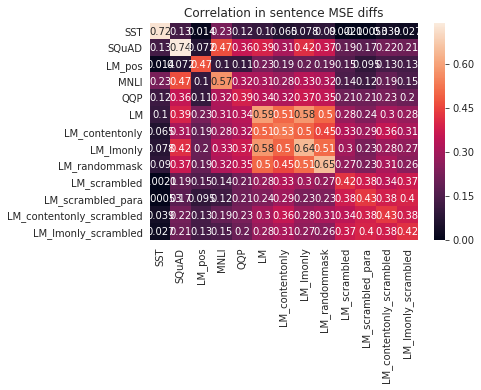

In [30]:
heatmap = pd.DataFrame(heatmap, index=bert_models, columns=bert_models)
sns.heatmap(data=heatmap, annot=True)
plt.title("Correlation in sentence MSE diffs")

### RSA in MSE diffs between model runs: LM_scrambled

In [31]:
avg_mse_diffs = mse_diffs.loc["LM_scrambled"].groupby("run").apply(lambda xs: xs.groupby("sentence").abs_mse.mean())
avg_mse_diffs.head()

sentence,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
run,,,,,,,,,,,,,,,,,,,,,
1,0.050761,0.060797,0.045492,0.072106,0.052391,0.067897,0.054485,0.047645,0.047118,0.068495,...,0.053487,0.055464,0.049600,0.043891,0.058229,0.067721,0.054228,0.036467,0.059577,0.047560
2,0.046340,0.059280,0.028677,0.057762,0.053552,0.047358,0.069851,0.060257,0.044575,0.057933,...,0.066719,0.057900,0.042053,0.044947,0.077629,0.074043,0.038687,0.038987,0.040952,0.051388
3,0.065261,0.074190,0.048346,0.066117,0.057404,0.051698,0.039987,0.057103,0.060071,0.036726,...,0.028994,0.041106,0.048370,0.025055,0.065542,0.084101,0.030171,0.022521,0.047304,0.059271
4,0.054274,0.064251,0.040633,0.042313,0.037878,0.035985,0.048984,0.037334,0.038426,0.073321,...,0.042157,0.046566,0.063917,0.029717,0.036721,0.073395,0.039262,0.033417,0.037558,0.057829
5,0.038474,0.058571,0.026051,0.061849,0.050679,0.048278,0.072436,0.060983,0.027519,0.042857,...,0.050518,0.049380,0.037732,0.023508,0.058510,0.055465,0.041506,0.026204,0.030664,0.031755


In [32]:
mse_corrs = {}
for pair in itertools.combinations(avg_mse_diffs.index, 2):
    mse_corrs[pair], _ = st.pearsonr(avg_mse_diffs.loc[pair[0]], avg_mse_diffs.loc[pair[1]])

In [33]:
idx = list(avg_mse_diffs.index)
heatmap = np.zeros((len(idx), len(idx)))
for i, model1 in enumerate(idx):
    for j, model2 in enumerate(idx):
            
        try:
            heatmap[i, j] = mse_corrs[model1, model2]
        except:
            heatmap[i, j] = mse_corrs.get((model2, model1), 1.0)

Text(0.5,1,'Correlation in sentence MSE diffs')

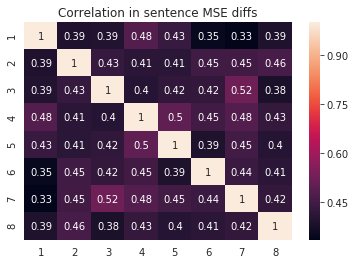

In [34]:
heatmap = pd.DataFrame(heatmap, index=idx, columns=idx)
sns.heatmap(data=heatmap, annot=True)
plt.title("Correlation in sentence MSE diffs")

Text(0.5,1,'LM_scrambled MSE diffs between runs')

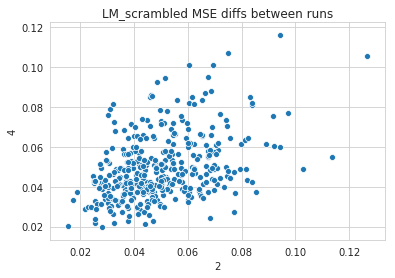

In [35]:
sns.scatterplot(x=2, y=4, data=avg_mse_diffs.T.reset_index())
plt.title("LM_scrambled MSE diffs between runs")

### RSA in MSE diffs between model runs: MNLI

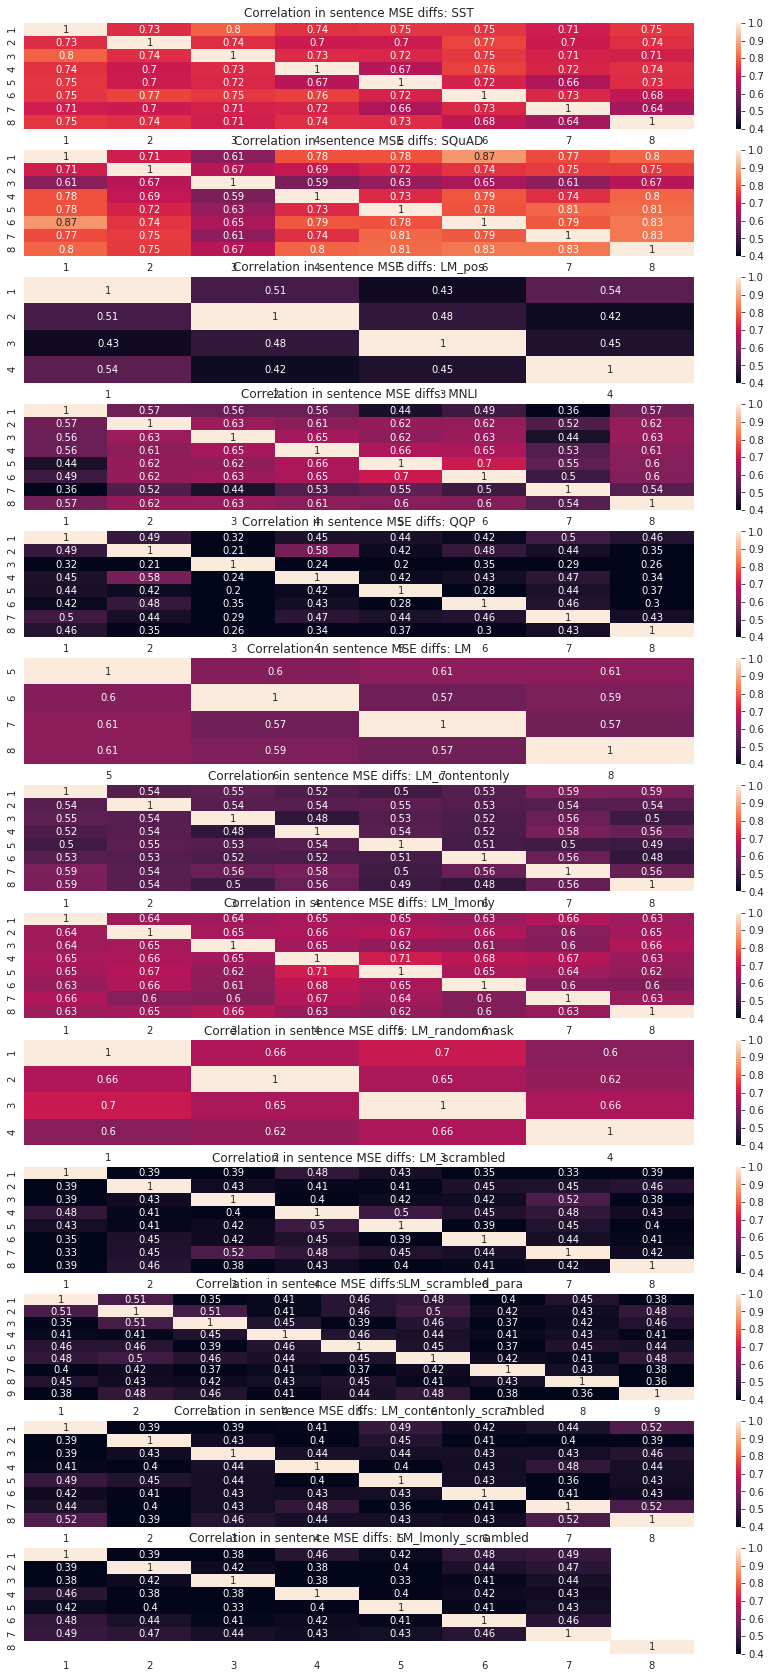

In [36]:
f, axs = plt.subplots(len(bert_models), figsize=(15, 30))
heatmaps = {}
for model, ax in tqdm_notebook(list(zip(bert_models, axs))):
    avg_mse_diffs = mse_diffs.loc[model].groupby("run").apply(lambda xs: xs.groupby("sentence").abs_mse.mean())
    mse_corrs = {}
    for pair in itertools.combinations(avg_mse_diffs.index, 2):
        mse_corrs[pair], _ = st.pearsonr(avg_mse_diffs.loc[pair[0]], avg_mse_diffs.loc[pair[1]])
        
    idx = list(avg_mse_diffs.index)
    heatmap = np.zeros((len(idx), len(idx)))
    for i, model1 in enumerate(idx):
        for j, model2 in enumerate(idx):

            try:
                heatmap[i, j] = mse_corrs[model1, model2]
            except:
                heatmap[i, j] = mse_corrs.get((model2, model1), 1.0)
                
    heatmaps[model] = pd.DataFrame(heatmap, index=idx, columns=idx)
    sns.heatmap(data=heatmaps[model], annot=True, ax=ax, vmin=0.4, vmax=1.0)
    ax.set_title("Correlation in sentence MSE diffs: %s" % model)

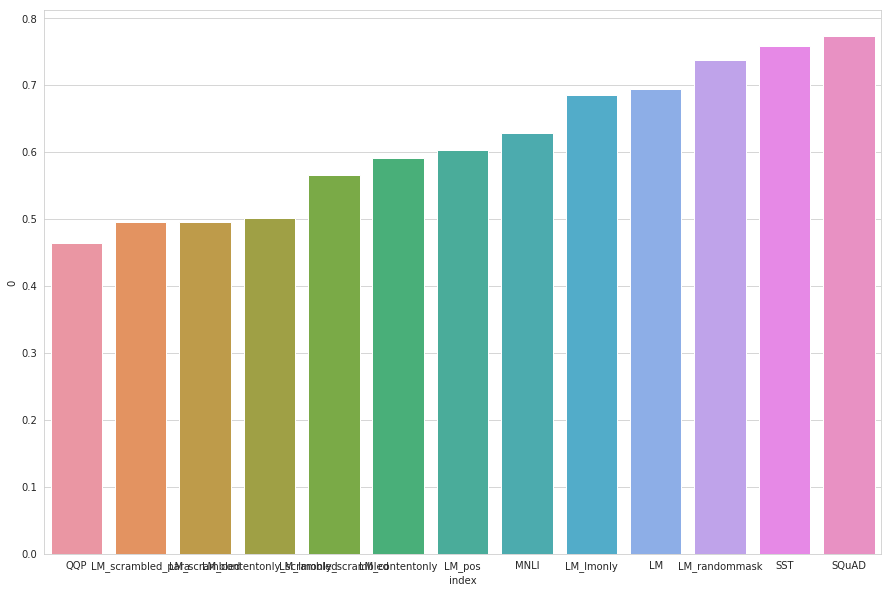

In [37]:
f, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x="index", y=0, data=pd.DataFrame.from_dict({k: v.mean().mean() for k, v in heatmaps.items()}, orient="index").sort_values(0).reset_index())

### RSA content analysis

In [38]:
rsa_inputs = {(model, run, step): enc for (model, run, step), enc in encodings.items()
              if int(step) == steps[-1]}
rsa_sims = rsa_encodings(rsa_inputs, collapse_fn=lambda key: key[0])

100%|██████████| 4656/4656 [02:59<00:00, 26.00it/s]


In [39]:
rsa_sims_avg = rsa_sims.groupby(["model1", "model2"]).pearsonr.mean()
rsa_sims_avg

model1                    model2                  
LM                        LM                          0.981313
                          LM_contentonly              0.950046
                          LM_contentonly_scrambled    0.915643
                          LM_lmonly                   0.963069
                          LM_lmonly_scrambled         0.901256
                          LM_randommask               0.943499
                          LM_scrambled                0.908497
                          LM_scrambled_para           0.898938
LM_contentonly            LM_contentonly              0.982327
                          LM_contentonly_scrambled    0.945836
                          LM_lmonly                   0.947185
                          LM_lmonly_scrambled         0.927460
                          LM_randommask               0.931054
                          LM_scrambled                0.927029
                          LM_scrambled_para           0.925790
LM_c

In [40]:
# Present sorted by avg correlation with LM_scrambled
rsa_sims_dict = rsa_sims_avg.to_dict()
rsa_sims_dict.update({(k2, k1): v for (k1, k2), v in rsa_sims_dict.items()})
model_order = sorted(bert_models, key=lambda m: rsa_sims_dict[m, "LM_scrambled"])
heatmap = np.zeros((len(model_order), len(model_order)))
for i, model1 in enumerate(model_order):
    for j, model2 in enumerate(model_order):
        try:
            heatmap[i, j] = rsa_sims_avg[model1, model2]
        except:
            heatmap[i, j] = rsa_sims_avg.get((model2, model1), 1.0)

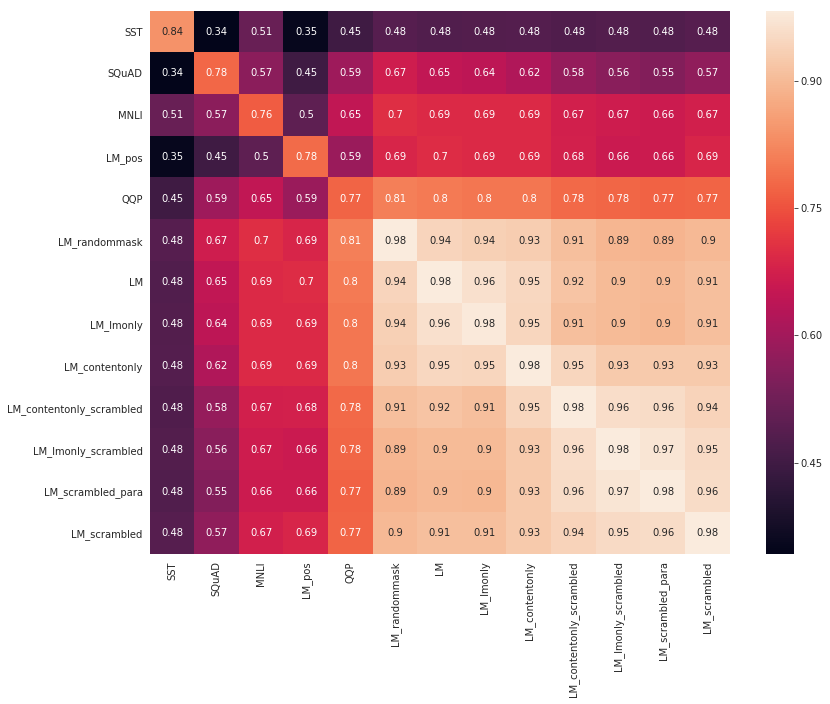

In [41]:
f, ax = plt.subplots(figsize=(13,10))
heatmap_df = pd.DataFrame(heatmap, index=model_order, columns=model_order)
sns.heatmap(data=heatmap_df, annot=True)

In [42]:
%matplotlib agg

# replot the above, but for report
rsa_sims_dict = rsa_sims_avg.to_dict()
rsa_sims_dict.update({(k2, k1): v for (k1, k2), v in rsa_sims_dict.items()})
model_order = sorted(report_models, key=lambda m: rsa_sims_dict[m, "LM_scrambled"])
heatmap = np.zeros((len(model_order), len(model_order)))
for i, model1 in enumerate(model_order):
    for j, model2 in enumerate(model_order):
        try:
            heatmap[i, j] = rsa_sims_avg[model1, model2]
        except:
            heatmap[i, j] = rsa_sims_avg.get((model2, model1), 1.0)
            
f, ax = plt.subplots(figsize=(13,10))
heatmap_df = pd.DataFrame(heatmap, index=model_order, columns=model_order)
sns.heatmap(data=heatmap_df, annot=True, annot_kws={"size": 15})
plt.tight_layout()
plt.savefig(figure_path / "rsa.png")
plt.close(f)

%matplotlib inline